## Importing Libraries

In [1]:
# from google.colab import drive
import os
import glob

## Mount Google Drive

In [2]:
# connects Google Drive to the Colab notebook.
# drive.mount('/content/drive')

## Define the paths to the "yes" and "no" folders

In [3]:
# yes = '/content/drive/MyDrive/Tumor Detection in Brain MRI Scans/brain_tumor_dataset/yes'
# no = '/content/drive/MyDrive/Tumor Detection in Brain MRI Scans/brain_tumor_dataset/no'
yes = './brain_tumor_dataset/yes'
no = './brain_tumor_dataset/no'

## Load all .jpg images into variables tumor and non-tumor

In [4]:
tumor = glob.glob(os.path.join(yes, '*.jpg')) + glob.glob(os.path.join(yes, '*.png'))
non_tumor = glob.glob(os.path.join(no, '*.jpg')) + glob.glob(os.path.join(no, '*.jpeg'))  + glob.glob(os.path.join(no, '*.png'))

## Check the number of images loaded

In [5]:
#some sample filenames
# print(f"Sample 'yes' files: {tumor[:5]}")
# print(f"Sample 'no' files: {non_tumor[:5]}")

# number of files
print(f"Number of 'yes' images: {len(tumor)}")
print(f"Number of 'no' images: {len(non_tumor)}")

Number of 'yes' images: 155
Number of 'no' images: 98


## Visualize Sample Images

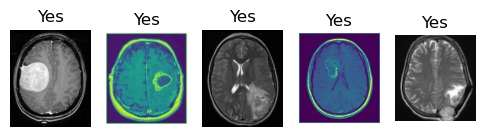

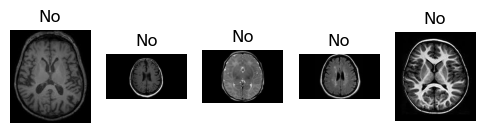

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display a list of images
def display_images(image_paths, title):
    plt.figure(figsize=(6, 3))
    for i, image_path in enumerate(image_paths[:5]):  # Show first 5 images
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Display sample images from the 'yes' and 'no' folders
display_images(tumor, 'Yes')
display_images(non_tumor, 'No')


## Custom Dataset Class

In [7]:
from torch.utils.data import Dataset # base class from the PyTorch library used to handle datasets.
from torchvision import transforms # transforming images, such as resizing or normalizing.
import torch

class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.yes_dir = os.path.join(root_dir, 'yes')
        self.no_dir = os.path.join(root_dir, 'no')
        self.yes_images = [(os.path.join(self.yes_dir, img), 1) for img in os.listdir(self.yes_dir)] # Creates a list of tuples for all images
        self.no_images = [(os.path.join(self.no_dir, img), 0) for img in os.listdir(self.no_dir)]
        self.all_images = self.yes_images + self.no_images
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


## Transformations

In [8]:
# transforms.Compose => Creating a recipe where list all the steps (transformations) you want to apply to an image
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Resizes the image to 224 pixels by 224 pixels
    transforms.ToTensor(), #type of data structure used in PyTorch to handle multi-dimensional arrays (like images)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagine adjusting the brightness and contrast of all your photos so they look more balanced and uniform
])


## Dataset Initialization

In [9]:
# Set the random seed for reproducibility
random_seed = 0
torch.manual_seed(random_seed)

# Initialize the dataset
dataset = BrainMRIDataset(root_dir='./brain_tumor_dataset', transform=transform)

# Calculate the sizes for train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset with a fixed random seed
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=35, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=35, shuffle=False)

## Print a few samples from the train data & test data

In [10]:
print("Train Data:")
for i in range(5):
    image, label = train_dataset[i]
    print(f"Image {i+1} - Label: {label}")

print("\nTest Data:")
for i in range(5):
    image, label = test_dataset[i]
    print(f"Image {i+1} - Label: {label}")

Train Data:
Image 1 - Label: 1
Image 2 - Label: 0
Image 3 - Label: 1
Image 4 - Label: 1
Image 5 - Label: 0

Test Data:
Image 1 - Label: 0
Image 2 - Label: 1
Image 3 - Label: 1
Image 4 - Label: 1
Image 5 - Label: 0


## Model Training

## Define and train custom ann

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F # provides functions for various operations, like activation functions.
import torch.optim as optim # contains optimization algorithms, used for training the model. => like Adam

# Define the custom ANN
class CustomANN(nn.Module): # CustomANN inherits from nn.Module, a base class for all neural network modules in PyTorch.
    def __init__(self):
        super(CustomANN, self).__init__() # Calls the constructor of the parent class (nn.Module).
        self.fc1 = nn.Linear(224*224*3, 512) # creates the first layer (fully connected) that takes an input of size 224x224x3 (which is the flattened image size) and outputs 512 features.
        self.fc2 = nn.Linear(512, 128) # This creates the second layer that takes the 512 features from the previous layer and outputs 128 features.
        self.fc3 = nn.Linear(128, 2) # This creates the third (final) layer that takes 128 features and outputs 2 values (e.g., for binary classification: tumor vs. no tumor).

    def forward(self, x): # This method defines how the data (input x) passes through the network.
        x = x.view(-1, 224*224*3)  #  Reshapes (flattens) the input image into a 1D tensor - Flatten the image
        x = F.relu(self.fc1(x))  # Passes the data through the first layer and applies the ReLU activation function, which adds non-linearity.
        x = F.relu(self.fc2(x))  # Passes the data through the second layer with ReLU activation.
        x = self.fc3(x)          # Passes the data through the final layer to get the output.
        return x

# Initialize the model, loss function, and optimizer
model_ann = CustomANN()
criterion = nn.CrossEntropyLoss() # Sets the loss function to CrossEntropyLoss, which is commonly used for classification tasks.
optimizer = optim.Adam(model_ann.parameters(), lr=0.001) # Initializes the Adam optimizer with the model's parameters and a learning rate of 0.001. The optimizer updates the model's weights during training.

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs): # Loops through the training process for a given number of epochs.
        correct_predictions = 0 # Initialize correct predictions counter
        total_samples = 0 # Initialize total samples counter
        running_loss = 0.0 # Initializes a variable to track the loss during training.
        for images, labels in train_loader: # Loops through the training data batch by batch.
            optimizer.zero_grad() # Clears the previous gradients to prevent accumulation
            outputs = model(images) # Passes the images through the model to get the predictions
            loss = criterion(outputs, labels) # Calculates the loss by comparing the predictions to the true labels.
            loss.backward() # Computes the gradients of the loss with respect to the model's parameters.
            optimizer.step() # Updates the model's parameters based on the computed gradients.
            running_loss += loss.item() # Accumulates the loss for the current epoch.

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability
            correct_predictions += (predicted == labels).sum().item() # Count correct predictions
            total_samples += labels.size(0) # Count total samples

        epoch_loss = running_loss / len(train_loader) # Average loss for the epoch
        epoch_accuracy = correct_predictions / total_samples * 100 # Accuracy for the epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%") # Print loss and accuracy
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}") # Prints the average loss for the current epoch.

# Train the model
train_model(model_ann, train_loader, criterion, optimizer)


Epoch 1/50, Loss: 18.0180, Accuracy: 57.43%
Epoch 2/50, Loss: 5.2652, Accuracy: 66.34%
Epoch 3/50, Loss: 1.8499, Accuracy: 79.70%
Epoch 4/50, Loss: 1.5771, Accuracy: 79.70%
Epoch 5/50, Loss: 0.4963, Accuracy: 89.11%
Epoch 6/50, Loss: 0.3003, Accuracy: 89.11%
Epoch 7/50, Loss: 0.1716, Accuracy: 94.55%
Epoch 8/50, Loss: 0.4932, Accuracy: 86.63%
Epoch 9/50, Loss: 0.7170, Accuracy: 86.14%
Epoch 10/50, Loss: 0.2061, Accuracy: 93.07%
Epoch 11/50, Loss: 0.1250, Accuracy: 96.53%
Epoch 12/50, Loss: 0.0319, Accuracy: 98.02%
Epoch 13/50, Loss: 0.0192, Accuracy: 99.50%
Epoch 14/50, Loss: 0.0154, Accuracy: 99.01%
Epoch 15/50, Loss: 0.0033, Accuracy: 100.00%
Epoch 16/50, Loss: 0.0081, Accuracy: 100.00%
Epoch 17/50, Loss: 0.0011, Accuracy: 100.00%
Epoch 18/50, Loss: 0.0012, Accuracy: 100.00%
Epoch 19/50, Loss: 0.0008, Accuracy: 100.00%
Epoch 20/50, Loss: 0.0007, Accuracy: 100.00%
Epoch 21/50, Loss: 0.0006, Accuracy: 100.00%
Epoch 22/50, Loss: 0.0005, Accuracy: 100.00%
Epoch 23/50, Loss: 0.0005, Accur

## Use Pre-trained VGG-Net and ResNet Models

In [12]:
from torchvision import models # torchvision is a package in PyTorch that provides easy access to pre-trained models, datasets, and image transformation functions.

# Load and modify VGG-Net
model_vgg = models.vgg16(weights='DEFAULT')
# model_vgg = models.vgg16(pretrained=True) # VGG16 is a type of Convolutional Neural Network (CNN) that is often used for image classification tasks. The pretrained=True argument loads a model that has been pre-trained on a large dataset (like ImageNet), which means it already knows how to recognize many common objects.
for param in model_vgg.parameters(): # (weights and biases) in the VGG16 model and set requires_grad to False. This means that during training, these parameters will not be updated.
    param.requires_grad = False
model_vgg.classifier[6] = nn.Linear(4096, 2)  # This line replaces the last layer of the VGG16 model. The original VGG16 model has a final layer with 4096 inputs and 1000 outputs (for 1000 classes). Here, we replace it with a layer that has 4096 inputs and 2 outputs, which is useful if we want to classify images into two categories.

# Load and modify ResNet
model_resnet = models.resnet18(weights='DEFAULT')
# model_resnet = models.resnet18(pretrained=True) # Similar to the VGG16 model, this line loads a pre-trained ResNet18 model. ResNet18 is another type of CNN that is known for its use of "residual blocks," which help the model learn better.
for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(512, 2)  # we replace the final fully connected layer of the ResNet18 model. The original ResNet18 model has a final layer with 512 inputs and 1000 outputs. We change it to have 512 inputs and 2 outputs for binary classification.

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # This section checks if a GPU is available. If it is, the models are moved to the GPU to speed up computation. If not, the models will be run on the CPU
model_vgg.to(device)
model_resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train Only the Last Layer of Pre-trained Models

In [13]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer only for the last layer.  In machine learning, an optimizer is used to update the weights of a model to minimize the loss (error). Here, the Adam optimizer is chosen for this task.
optimizer_vgg = optim.Adam(model_vgg.classifier[6].parameters(), lr=0.001) # We are specifying that the optimizer should only update the parameters (weights) of the last layer (layer 6) of the classifier in the VGG16 model.
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001) # optimizer should update only the last layer (fc) of the ResNet18 model.

# Training function for pre-trained models with accuracy calculation
def train_pretrained_model(model, train_loader, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in train_loader: #This loop iterates through the batches of images and labels (their corresponding correct categories) from the train_loader.
            images, labels = images.to(device), labels.to(device) # The images and labels are moved to the GPU (if available) to speed up computation.
            optimizer.zero_grad() # Before making any updates to the weights, this line clears the gradients from the previous step to avoid accumulation.
            outputs = model(images) # The images are passed through the model to get the predictions (outputs).
            loss = criterion(outputs, labels) # The difference between the model's predictions (outputs) and the actual labels is calculated using a loss function (criterion). The loss function measures how far off the predictions are from the actual labels.
            loss.backward() # This computes the gradients for each parameter with respect to the loss, which is necessary for updating the model's weights.
            optimizer.step() # The optimizer updates the model’s weights based on the calculated gradients.
            running_loss += loss.item() # The loss for this batch is added to the running total for the current epoch.

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0) # Here, the model’s predictions are compared to the actual labels to determine how many were correct. torch.max(outputs, 1) gives the predicted label, and the number of correct predictions is added to correct_predictions

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples * 100 # At the end of each epoch, the average loss and accuracy for that epoch are calculated.

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")




In [14]:
# Train VGG-Net with accuracy monitoring
train_pretrained_model(model_vgg, train_loader, optimizer_vgg)

Epoch 1/50, Loss: 0.6364, Accuracy: 62.87%
Epoch 2/50, Loss: 0.4926, Accuracy: 77.72%
Epoch 3/50, Loss: 0.4190, Accuracy: 78.71%
Epoch 4/50, Loss: 0.4131, Accuracy: 80.69%
Epoch 5/50, Loss: 0.3619, Accuracy: 86.63%
Epoch 6/50, Loss: 0.3260, Accuracy: 88.12%
Epoch 7/50, Loss: 0.2985, Accuracy: 86.63%
Epoch 8/50, Loss: 0.2842, Accuracy: 88.61%
Epoch 9/50, Loss: 0.3008, Accuracy: 87.62%
Epoch 10/50, Loss: 0.3101, Accuracy: 87.13%
Epoch 11/50, Loss: 0.2693, Accuracy: 90.59%
Epoch 12/50, Loss: 0.2985, Accuracy: 88.12%
Epoch 13/50, Loss: 0.2393, Accuracy: 91.58%
Epoch 14/50, Loss: 0.2550, Accuracy: 89.11%
Epoch 15/50, Loss: 0.2464, Accuracy: 88.61%
Epoch 16/50, Loss: 0.2376, Accuracy: 89.11%
Epoch 17/50, Loss: 0.2446, Accuracy: 91.09%
Epoch 18/50, Loss: 0.2396, Accuracy: 90.10%
Epoch 19/50, Loss: 0.1853, Accuracy: 95.05%
Epoch 20/50, Loss: 0.1852, Accuracy: 94.55%
Epoch 21/50, Loss: 0.2004, Accuracy: 91.58%
Epoch 22/50, Loss: 0.2332, Accuracy: 91.09%
Epoch 23/50, Loss: 0.1783, Accuracy: 94.5

In [15]:
# Train ResNet with accuracy monitoring
train_pretrained_model(model_resnet, train_loader, optimizer_resnet)

Epoch 1/50, Loss: 0.7019, Accuracy: 54.95%
Epoch 2/50, Loss: 0.5886, Accuracy: 68.81%
Epoch 3/50, Loss: 0.5088, Accuracy: 75.25%
Epoch 4/50, Loss: 0.4523, Accuracy: 79.70%
Epoch 5/50, Loss: 0.4689, Accuracy: 77.72%
Epoch 6/50, Loss: 0.3879, Accuracy: 81.68%
Epoch 7/50, Loss: 0.3996, Accuracy: 82.18%
Epoch 8/50, Loss: 0.3492, Accuracy: 85.15%
Epoch 9/50, Loss: 0.3238, Accuracy: 88.12%
Epoch 10/50, Loss: 0.3237, Accuracy: 88.61%
Epoch 11/50, Loss: 0.3161, Accuracy: 87.62%
Epoch 12/50, Loss: 0.2785, Accuracy: 89.60%
Epoch 13/50, Loss: 0.2640, Accuracy: 91.58%
Epoch 14/50, Loss: 0.2671, Accuracy: 92.08%
Epoch 15/50, Loss: 0.2695, Accuracy: 89.60%
Epoch 16/50, Loss: 0.2400, Accuracy: 94.55%
Epoch 17/50, Loss: 0.2459, Accuracy: 93.56%
Epoch 18/50, Loss: 0.2728, Accuracy: 88.61%
Epoch 19/50, Loss: 0.2439, Accuracy: 90.59%
Epoch 20/50, Loss: 0.2131, Accuracy: 96.04%
Epoch 21/50, Loss: 0.2694, Accuracy: 89.11%
Epoch 22/50, Loss: 0.2090, Accuracy: 94.55%
Epoch 23/50, Loss: 0.2147, Accuracy: 93.0

## Evaluate Each Model

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, data_loader, device):
    model.to(device)  # Move the model to the specified device
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure both images and labels are on the same device
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU before converting to NumPy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU before converting to NumPy
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')

    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, precision, recall, cm

# Assume 'device' is already defined as 'cuda' or 'cpu'
# Evaluate models
acc_ann, precision_ann, recall_ann, cm_ann = evaluate_model(model_ann, test_loader, device)
acc_vgg, precision_vgg, recall_vgg, cm_vgg = evaluate_model(model_vgg, test_loader, device)
acc_resnet, precision_resnet, recall_resnet, cm_resnet = evaluate_model(model_resnet, test_loader, device)

print("ANN Metrics:")
print(f"Accuracy: {acc_ann:.4f}, Precision: {precision_ann:.4f}, Recall: {recall_ann:.4f}")
print(f"Confusion Matrix:\n{cm_ann}")

print("\nVGG-Net Metrics:")
print(f"Accuracy: {acc_vgg:.4f}, Precision: {precision_vgg:.4f}, Recall: {recall_vgg:.4f}")
print(f"Confusion Matrix:\n{cm_vgg}")

print("\nResNet Metrics:")
print(f"Accuracy: {acc_resnet:.4f}, Precision: {precision_resnet:.4f}, Recall: {recall_resnet:.4f}")
print(f"Confusion Matrix:\n{cm_resnet}")


ANN Metrics:
Accuracy: 0.8039, Precision: 0.8049, Recall: 0.8039
Confusion Matrix:
[[13  7]
 [ 3 28]]

VGG-Net Metrics:
Accuracy: 0.8824, Precision: 0.8827, Recall: 0.8824
Confusion Matrix:
[[16  4]
 [ 2 29]]

ResNet Metrics:
Accuracy: 0.8627, Precision: 0.8621, Recall: 0.8627
Confusion Matrix:
[[16  4]
 [ 3 28]]


In [17]:
# Determine the best model based on accuracy
best_accuracy = max(acc_ann, acc_vgg, acc_resnet)
if best_accuracy == acc_ann:
    best_model = model_ann
    best_model_name = 'ANN'
elif best_accuracy == acc_vgg:
    best_model = model_vgg
    best_model_name = 'VGG-Net'
else:
    best_model = model_resnet
    best_model_name = 'ResNet'

# print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

# # Save the best model
# torch.save(best_model.state_dict(), f'{best_model_name}_best_model.pth')
# print(f"{best_model_name} model saved as {best_model_name}_best_model.pth")

# Define the save path to Google Drive
save_path = './'

# Save the best model to Google Drive
# torch.save(best_model.state_dict(), save_path + f'{best_model_name}_best_model.pth')
torch.save(best_model, save_path + f'{best_model_name}_best_model.pth')
print(f"{best_model_name} model saved as {save_path}{best_model_name}_best_model.pth")

VGG-Net model saved as ./VGG-Net_best_model.pth


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, precision, recall, cm

# Evaluate models
acc_ann, precision_ann, recall_ann, cm_ann = evaluate_model(model_ann, test_loader)
acc_vgg, precision_vgg, recall_vgg, cm_vgg = evaluate_model(model_vgg, test_loader)
acc_resnet, precision_resnet, recall_resnet, cm_resnet = evaluate_model(model_resnet, test_loader)

print("ANN Metrics:")
print(f"Accuracy: {acc_ann}, Precision: {precision_ann}, Recall: {recall_ann}")
print(f"Confusion Matrix:\n{cm_ann}")

print("\nVGG-Net Metrics:")
print(f"Accuracy: {acc_vgg}, Precision: {precision_vgg}, Recall: {recall_vgg}")
print(f"Confusion Matrix:\n{cm_vgg}")

print("\nResNet Metrics:")
print(f"Accuracy: {acc_resnet}, Precision: {precision_resnet}, Recall: {recall_resnet}")
print(f"Confusion Matrix:\n{cm_resnet}")


ANN Metrics:
Accuracy: 0.803921568627451, Precision: 0.8049019607843136, Recall: 0.803921568627451
Confusion Matrix:
[[13  7]
 [ 3 28]]

VGG-Net Metrics:
Accuracy: 0.8823529411764706, Precision: 0.8827490592196474, Recall: 0.8823529411764706
Confusion Matrix:
[[16  4]
 [ 2 29]]

ResNet Metrics:
Accuracy: 0.8627450980392157, Precision: 0.8621001031991743, Recall: 0.8627450980392157
Confusion Matrix:
[[16  4]
 [ 3 28]]
